In [7]:
import pandas as pd

In [21]:
def filter_by_dollar_volume(df, n_stocks=1500, lookback_days=20, rebalance_frequency='Y'):
    df = df.copy()
    df['dollar_volume'] = df['close'] * df['volume']
    
    # Sort by symbol and date
    df = df.sort_values(['symbol', df.index.name or 'date'])
    
    # Calculate rolling average dollar volume with min_periods=1
    df['avg_dollar_volume'] = df.groupby('symbol', group_keys=False)['dollar_volume'].transform(
        lambda x: x.rolling(window=lookback_days, min_periods=1).mean()
    )
    
    # Get rebalance dates (first date of each period)
    rebalance_dates = df.groupby(df.index.to_period(rebalance_frequency)).apply(lambda x: x.index.min())
    
    selected_data = []
    
    for i in range(len(rebalance_dates)):
        rebal_date = rebalance_dates.iloc[i]
        
        # Define period range
        if i + 1 < len(rebalance_dates):
            end_date = rebalance_dates.iloc[i + 1]
        else:
            end_date = df.index.max() + pd.Timedelta(days=1)
        
        # Get data at rebalance date to select universe
        selection_data = df[df.index == rebal_date].copy()
        
        if len(selection_data) == 0:
            continue
            
        # Select top N stocks by avg dollar volume
        top_stocks = selection_data.nlargest(n_stocks, 'avg_dollar_volume')['symbol'].unique()
        
        # Keep these stocks for the entire period
        period_data = df[(df.index >= rebal_date) & 
                        (df.index < end_date) & 
                        (df['symbol'].isin(top_stocks))].copy()
        
        selected_data.append(period_data)
    
    if len(selected_data) == 0:
        return pd.DataFrame()
    
    filtered = pd.concat(selected_data, ignore_index=False)
    return filtered.drop(columns=['dollar_volume', 'avg_dollar_volume'])

In [22]:
df = pd.read_csv('stock_prices_latest.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date', drop=True)

# Debug: check what you have
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Number of unique symbols: {df['symbol'].nunique()}")
print(f"Total rows: {len(df)}")

df_filtered = filter_by_dollar_volume(df, n_stocks=1500, lookback_days=250)

print(f"\nAfter filtering: {len(df_filtered)} rows")

if len(df_filtered) > 0:
    df_filtered = df_filtered.reset_index()
    df_filtered = df_filtered[df_filtered['date'] >= '2000-01-01']
    df_filtered = df_filtered[df_filtered['date'] <= '2020-01-01']
    print(f"After date filtering: {len(df_filtered)} rows")
    
    # Check stocks per day
    stocks_per_day = df_filtered.groupby('date')['symbol'].nunique()
    print(f"Avg stocks per day: {stocks_per_day.mean():.0f}")
    print(f"Min stocks per day: {stocks_per_day.min()}")
    print(f"Max stocks per day: {stocks_per_day.max()}")

Date range: 1998-01-02 00:00:00 to 2021-06-14 00:00:00
Number of unique symbols: 7786
Total rows: 24395016

After filtering: 8811775 rows
After date filtering: 7525705 rows
Avg stocks per day: 1496
Min stocks per day: 1419
Max stocks per day: 1500


<Axes: title={'center': 'Stocks in Universe'}, xlabel='date'>

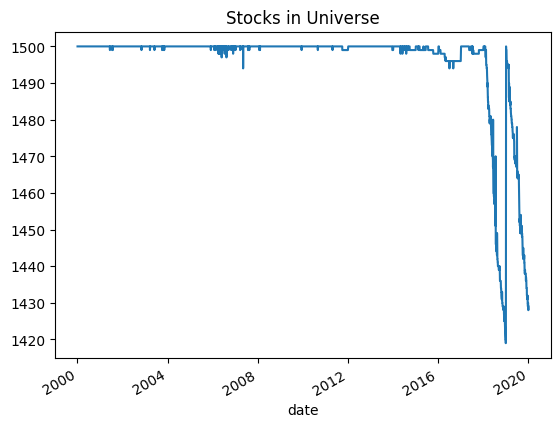

In [28]:
df_filtered.groupby('date')['symbol'].nunique().plot(title='Stocks in Universe')

In [36]:
df = df_filtered.set_index('date').sort_index().loc[:'2018-01-01']

<Axes: title={'center': 'Stocks in Universe'}, xlabel='date'>

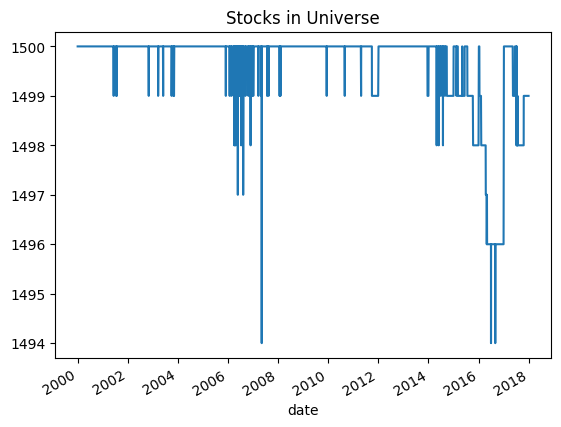

In [37]:
df.groupby('date')['symbol'].nunique().plot(title='Stocks in Universe')

In [39]:
import numpy as np

# Split into N equal pieces
n_pieces = 4
chunks = np.array_split(df, n_pieces)

# Save each chunk
for i, chunk in enumerate(chunks):
    chunk.to_csv(f'output_part_{i+1}.csv', index=False)